In [16]:
from dotenv import load_dotenv
import os
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings

# 환경변수 로드
load_dotenv()

# API 키 불러오기
openai_api_key = os.environ["OPENAI_API_KEY"]
pinecone_api_key = os.environ["PINECONE_API_KEY"]
pinecone_index_name = "boazpubmed"  # 🔁 인덱스 이름 확인

# 임베딩 모델 정의
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", api_key=openai_api_key)

# Pinecone 연결
pc = Pinecone(api_key=pinecone_api_key)
index = pc.Index(pinecone_index_name)

# LangChain VectorStore 생성
vectorstore = PineconeVectorStore(
    index=index,
    embedding=embeddings,
    text_key="page_content"
)

# Retriever 설정
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

query = "심장 초음파로 폐동맥압을 분석하는 연구는?"
docs = retriever.invoke(query)

for i, doc in enumerate(docs, 1):
    print(f"문서 {i}")
    print(f"ID: {getattr(doc, 'id', doc.metadata.get('source', 'N/A'))}")
    print(f"paper_title: {doc.metadata.get('paper_title', '제목 없음')}")
    print(f"year: {doc.metadata.get('year', '연도 없음')}")
    print("\npage_content:")
    print(doc.page_content[:500])
    print("-" * 80)



문서 1
ID: pubmed_16988
paper_title: Use of the Esophageal Doppler Machine to help guide the intraoperative management of two children with pheochromocytoma.
year: 2006.0

page_content:
Use of the Esophageal Doppler Machine to help guide the intraoperative management of two children with pheochromocytoma.

The anesthetic management of pheochromocytoma has been based upon the intraoperative control of blood pressure and fluid balance following adequate preoperative preparation. This can be difficult, especially in the presence of significant comorbidity such as cardiac or renal dysfunction. Two cases of children with pheochromocytoma are reported where the introperative manageme
--------------------------------------------------------------------------------
문서 2
ID: pubmed_3737
paper_title: Hands-Only Cardiopulmonary Resuscitation Education for Elementary School Students in Korea: Tracking by School Grade, Physical Characteristics, and Physical Strength.
year: 2023.0

page_content:
Hands

In [4]:
from typing import Annotated, List, TypedDict
from langgraph.graph.message import add_messages
from langchain_community.document_transformers import LongContextReorder
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from mcp import ClientSession, StdioServerParameters
from langchain_mcp_adapters.client import MultiServerMCPClient
from openai import OpenAI

load_dotenv()

model_client = OpenAI()

class ChatbotState(TypedDict):
    question: Annotated[str, "Question"]  
    tools: Annotated[List, "Tools"]
    neo4j_documents: Annotated[List, "Neo4j_Documents"]  
    vector_documents : Annotated[List,"Vector_Documents"]
    final_answer: Annotated[str, "Final_Answer"]  
    messages: Annotated[List, add_messages] 

memory = MemorySaver()

# MCP Multi-Tool Client
client = MultiServerMCPClient(
    {
        "neo4j_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/mnt/c/Users/user/BOAZ_ADV/Hyewon/mcp/mcp_neo4j_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/mnt/c/Users/user/BOAZ_ADV/Hyewon/mcp/mcp_vectordb_server.py"],
            "transport": "stdio",
        },
    }
)

tools = await client.get_tools()

tools_dict = {tool.name: tool for tool in tools}

print(tools_dict)

{'neo4j_retriever': StructuredTool(name='neo4j_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'neo4j_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7211476c2560>), 'VectorDB_retriever': StructuredTool(name='VectorDB_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'VectorDB_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7211476c2b00>)}


In [5]:
tools = [
    {
        "type": "function",
        "name": "neo4j_retriever",
        "description": "Query structured patient-related data, such as surgeries, lab results, or graph-based records.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query about the patient's clinical records"
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    },
    {
        "type": "function",
        "name": "VectorDB_retriever",
        "description": "Retrieve general medical knowledge (diseases, treatments, guidelines).",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query about medical knowledge"
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    }
]

In [6]:
LLM_SYSTEM_PROMPTY = """
# INSTRUCTION
당신은 의료 데이터에 특화된 전문가 AI입니다.
사용자의 질문에 대해 다음 두 가지 출처의 정보를 참고하여 답변을 생성하세요:

1. 🔎 Neo4j 검색 결과: 구조화된 환자 관련 정보 (예: 수술 이력, 검사 기록 등)
2. 📚 VectorDB 검색 결과: 일반적인 의학 지식 (예: 증상 설명, 치료 가이드라인 등)

- 두 결과 모두 존재할 경우, 각 출처를 구분하여 통합적으로 반영하되, 중복 내용은 요약하거나 통합하세요.
- 한 쪽의 결과만 존재할 경우, 해당 결과만을 바탕으로 답변하되, 정보의 한계에 대해 언급하지 말고 최대한 성실히 답변하세요.
- 결과가 너무 적거나 애매하더라도 반드시 유의미한 설명을 제공하려고 노력하세요.
- 불필요한 서론 없이, 질문에 바로 답변하세요.

# Neo4j CONTEXT
{Neo4j}

# Vector DB CONTEXT
{VectorDB}

# Question
{question}
"""

model = ChatOpenAI(temperature=0.2,
                      model_name="gpt-4o")

In [7]:
async def decision_tools(state: ChatbotState):
    
    question = state["question"]

    input_messages = [
        {"role": "system", "content": "Decide which tools to use to answer the user's question. You may call one or both."},
        {"role": "user", "content": question}
    ]
    
    response = model_client.responses.create(model="gpt-4.1",
                                             input=input_messages,
                                             tools=tools)

    selected_tools = [tool.name for tool in response.output]

    return ChatbotState(tools=selected_tools)

async def vector_db(state: ChatbotState):
    question = state["question"]
    
    if "VectorDB_retriever" in state["tools"]:
        vectordb_tool = tools_dict["VectorDB_retriever"]
        
        if vectordb_tool:
            result = await vectordb_tool.ainvoke({"query": question})
        else:
            result = "VectorDB 도구를 찾을 수 없습니다."
    else:
        result = None

    return ChatbotState(vector_documents=result)

async def neo4j_db(state: ChatbotState):
    question = state["question"]
    
    if "neo4j_retriever" in state["tools"]:
        neo4j_tool = tools_dict.get("neo4j_retriever")
        if neo4j_tool:
            result = await neo4j_tool.ainvoke({"query": question})
        else:
            result = "Neo4j 도구를 찾을 수 없습니다."
    else:
        result = None

    return ChatbotState(neo4j_documents=result)

async def merge_outputs(state:ChatbotState):

    question = state['question']
    vector_documents = state['vector_documents']
    neo4j_documents = state['neo4j_documents']

    formatted = LLM_SYSTEM_PROMPTY.format(Neo4j = neo4j_documents,
                                          VectorDB = vector_documents,
                                          question = question)
    response = model.invoke(formatted)
    response_text = response.content if isinstance(response, AIMessage) else str(response)

    return ChatbotState(final_answer=response_text,
                        messages=[("user", question), ("assistant", response_text)])

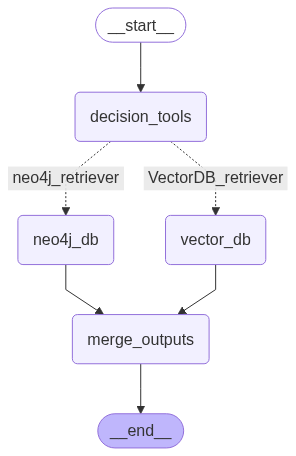

In [8]:
builder = StateGraph(ChatbotState)

builder.add_node("decision_tools", decision_tools)
builder.add_node("vector_db", vector_db)
builder.add_node("neo4j_db", neo4j_db)
builder.add_node("merge_outputs", merge_outputs)

builder.add_edge(START, "decision_tools")

def route_tools(state: ChatbotState):
    return state["tools"]

builder.add_conditional_edges(
    "decision_tools",
    route_tools,
    {
        "neo4j_retriever": "neo4j_db",
        "VectorDB_retriever": "vector_db"
    }
)

builder.add_edge("neo4j_db", "merge_outputs")
builder.add_edge("vector_db", "merge_outputs")
builder.add_edge("merge_outputs", END)

builder.compile(checkpointer=memory)

In [15]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": 1})

question = "Kasabach-Merrritt Syndrome이 뭐야?"

graph = builder.compile(checkpointer=memory)

initial_state = {
    "question": question,
    "tools": [],
    "neo4j_documents": [],
    "vector_documents": [],
    "final_answer": "",
    "messages": [],
}

events = []
async for event in graph.astream(initial_state, config=config):
    print(event)


{'decision_tools': {'tools': ['VectorDB_retriever']}}
{'vector_db': {'vector_documents': 'Laparoscopic cholecystectomy for symptomatic cholecystolithiasis (CCL) in "Kasabach-Merritt syndrome" (KMS) (Kaposi-tumor like hemangioendothelioma with case-specific perioperative management).\n\nOBJECTIVES: The Kasabach-Merritt syndrome (KMS) is characterized by the occurrence of hemangioendothelioma (giant hemangioma with thrombosis leading to thrombocytopenia), which can be associated with disseminated intravasal coagulation. Specific aim: Based on (i) selective references from the current scientific literature and derived recommendations as well as (ii) own experiences obtained in the diagnostic and perioperative management of a representative case from daily practice in abdominal surgery, the specific case undergoing elective cholecystectomy (CCE) in KMS is to be described by means of scientific case report.\nCASE PRESENTATION: (Patient-, finding- and treatment-specific characteristics): - M